In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from dataset import MyDataset
from IPython.display import Markdown, display
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2

## Часть 1

### Подготовка данных

In [7]:
data = MyDataset(
    folder="/home/oleg/Downloads/!MCWD",
    transform=v2.Compose([
        v2.Resize((128, 128)),
        v2.ToDtype(torch.float32, scale=True),
    ])
)

In [8]:
train, valid = random_split(
    data, [0.8, 0.2]
)

In [9]:
display(
    Markdown(f"Shape {tuple(train[0][0].shape)}"), 
    Markdown(f"Min {train[0][0].min():.2}"),
    Markdown(f"Max {train[0][0].max():.2}"),
)

Shape (3, 128, 128)

Min 0.031

Max 1.0

### Построение модели

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, kernel_size: int = 3):
        super().__init__()
        self.flatten = nn.Flatten()
        padding = (kernel_size-1) // 2
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(4, 4),
            nn.Conv2d(32, 64, kernel_size, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(4, 4),
        )
        size = 64 * (128//16)**2
        self.classif = nn.Sequential(
            nn.Linear(size, size),
            nn.ReLU(),
            nn.Linear(size, 4),
        )

    def forward(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, 1)
        x = self.classif(x)
        return x


model = NeuralNetwork()

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Обучение и оценка

In [18]:
from collections import defaultdict

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from torcheval.metrics import MulticlassAccuracy
from tqdm import tqdm

In [19]:
sns.set_theme()

In [20]:
trainloader = DataLoader(train, batch_size=16, shuffle=True)

In [21]:
log = defaultdict(list)
for epoch in range(10):
    log["train_loss"].append(0)
    accuracy = MulticlassAccuracy()
    for i, (inputs, labels) in tqdm(
        enumerate(trainloader),
        total=57,
        leave=False,
        desc=f"epoch {epoch}"
    ):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        log["train_loss"][-1] += float(loss)
        accuracy.update(outputs, labels)
    log["train_accuracy"].append(float(accuracy.compute()))
        
    log["valid_loss"].append(0)
    accuracy = MulticlassAccuracy()
    with torch.no_grad():
        for inputs, labels in DataLoader(valid):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            log["valid_loss"][-1] += float(loss)
            accuracy.update(outputs, labels)
    log["valid_accuracy"].append(float(accuracy.compute()))

KeyboardInterrupt: 

In [ ]:
log['index'] = range(len(log['train_loss']))
loss = pd.melt(
    frame=pd.DataFrame(log),
    id_vars='index',
    value_vars=['train_loss', 'valid_loss']
)
accuracy = pd.melt(
    frame=pd.DataFrame(log),
    id_vars='index',
    value_vars=['train_accuracy', 'valid_accuracy']
)

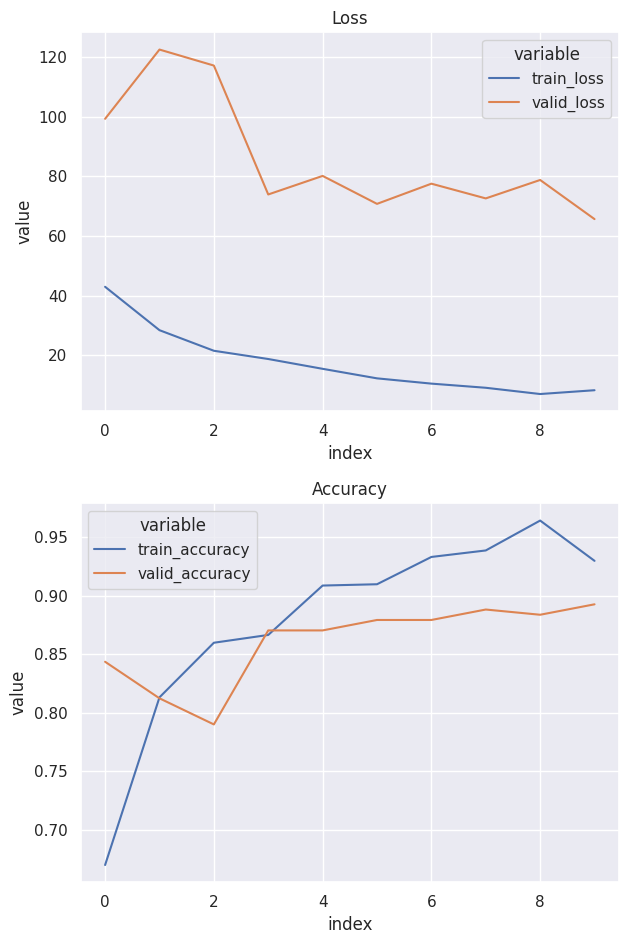

In [ ]:
ax = plt.subplot(2, 1, 1)
ax.set_title("Loss")
sns.lineplot(loss, x='index', y='value', hue='variable', ax=ax)
ax = plt.subplot(2, 1, 2)
ax.set_title("Accuracy")
sns.lineplot(accuracy, x='index', y='value', hue='variable', ax=ax)
plt.tight_layout(rect=(0, 0, 1, 2))

Точность валидации хорошая